In [10]:
# CELDA A: imports y funciones
%matplotlib inline
import numpy as np
import cv2 as cv
import matplotlib.pyplot as plt

# --- tu función de SIFT+grayscale (paso 1–2) ---
sift2 = cv.SIFT_create()
def detect_and_compute(img):
    gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
    kp, des = sift2.detectAndCompute(gray, None)
    return kp, des

# --- función compute_homography (paso 3) ---
def compute_homography(kp_src, des_src, kp_dst, des_dst,
                       ratio=0.75, min_matches=10):
    flann = cv.FlannBasedMatcher(
        dict(algorithm=1, trees=5),
        dict(checks=50)
    )
    matches = flann.knnMatch(des_src, des_dst, k=2)
    good = [m for m,n in matches if m.distance < ratio*n.distance]
    if len(good) < min_matches:
        raise RuntimeError(f"Pocos matches: {len(good)}/{min_matches}")
    src_pts = np.float32([kp_src[m.queryIdx].pt for m in good])\
              .reshape(-1,1,2)
    dst_pts = np.float32([kp_dst[m.trainIdx].pt for m in good])\
              .reshape(-1,1,2)
    H, _ = cv.findHomography(src_pts, dst_pts, cv.RANSAC, 5.0)
    return H.astype(np.float32)

# --- función warp_and_accumulate (paso 4) ---
def warp_and_accumulate(img, H, T, canvas_shape, accumulator, count_map):
    warped = cv.warpPerspective(
        img,
        T.dot(H),
        (canvas_shape[1], canvas_shape[0]),
        flags=cv.INTER_LINEAR,
        borderMode=cv.BORDER_CONSTANT,
        borderValue=(0,0,0)
    )
    mask = (warped.sum(axis=2) > 0)
    accumulator[mask] += warped[mask]
    count_map[mask]   += 1


(-0.5, 3887.5, 2591.5, -0.5)

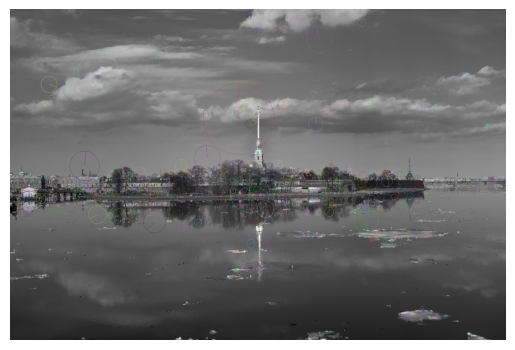

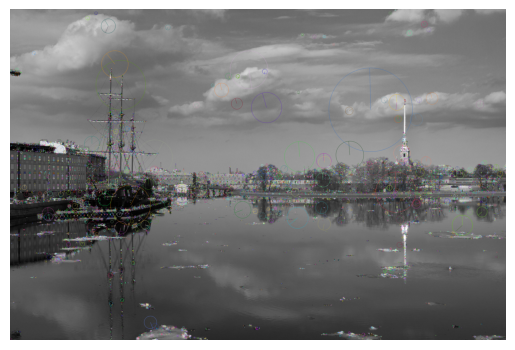

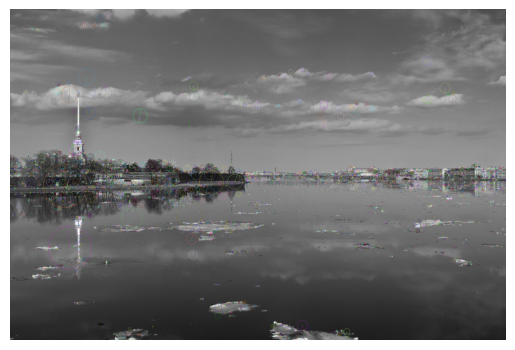

In [11]:
# CELDA B: carga de imágenes y SIFT keypoints
central = cv.imread('data/images/boat2.jpg')
left    = cv.imread('data/images/boat1.jpg')
right   = cv.imread('data/images/boat3.jpg')

# tu bloque original de SIFT+drawKeypoints
grayc = cv.cvtColor(central, cv.COLOR_BGR2GRAY)
kpc, desc_c = sift2.detectAndCompute(grayc, None)
central_kpvis = cv.drawKeypoints(grayc, kpc, None,
                                 flags=cv.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
plt.imshow(central_kpvis, cmap='gray'); plt.axis('off')

gray = cv.cvtColor(left, cv.COLOR_BGR2GRAY)
kpl, desc_l = sift2.detectAndCompute(gray, None)
left_kpvis = cv.drawKeypoints(gray, kpl, None,
                              flags=cv.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
plt.figure(); plt.imshow(left_kpvis, cmap='gray'); plt.axis('off')

gray = cv.cvtColor(right, cv.COLOR_BGR2GRAY)
kpr, desc_r = sift2.detectAndCompute(gray, None)
right_kpvis = cv.drawKeypoints(gray, kpr, None,
                               flags=cv.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
plt.figure(); plt.imshow(right_kpvis, cmap='gray'); plt.axis('off')


(-0.5, 7775.5, 2591.5, -0.5)

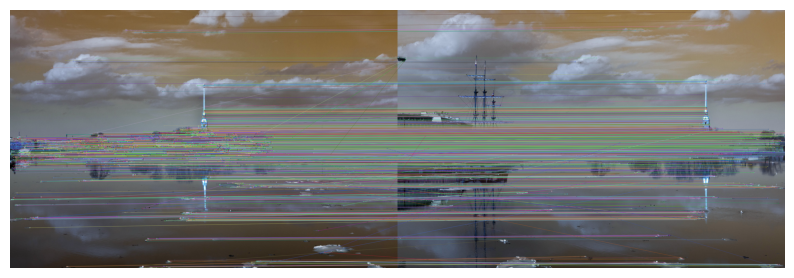

In [12]:
# CELDA C: matching manual (opcional, puedes saltarte esto)
bf = cv.BFMatcher()
matches = bf.knnMatch(desc_c, desc_l, k=2)
good = [[m] for m,n in matches if m.distance < 0.75*n.distance]
match_vis = cv.drawMatchesKnn(central, kpc, left, kpl, good, None,
                              flags=cv.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
plt.figure(figsize=(10,5)); plt.imshow(match_vis); plt.axis('off')


In [13]:
# CELDA D: paso 3 – homografías
H_left  = compute_homography(kpl, desc_l, kpc, desc_c)
H_right = compute_homography(kpr, desc_r, kpc, desc_c)
print("H_left:\n", H_left, "\nH_right:\n", H_right)


H_left:
 [[ 1.2385746e+00  2.8231803e-03 -1.5112628e+03]
 [ 7.8858778e-02  1.1482437e+00 -1.6566173e+02]
 [ 6.3134161e-05 -2.6982621e-06  1.0000000e+00]] 
H_right:
 [[ 7.5744998e-01  3.1367214e-03  1.4695270e+03]
 [-9.2994273e-02  9.1558242e-01  1.7453299e+02]
 [-6.1253639e-05 -2.7435076e-06  1.0000000e+00]]


(-0.5, 7374.5, 3141.5, -0.5)

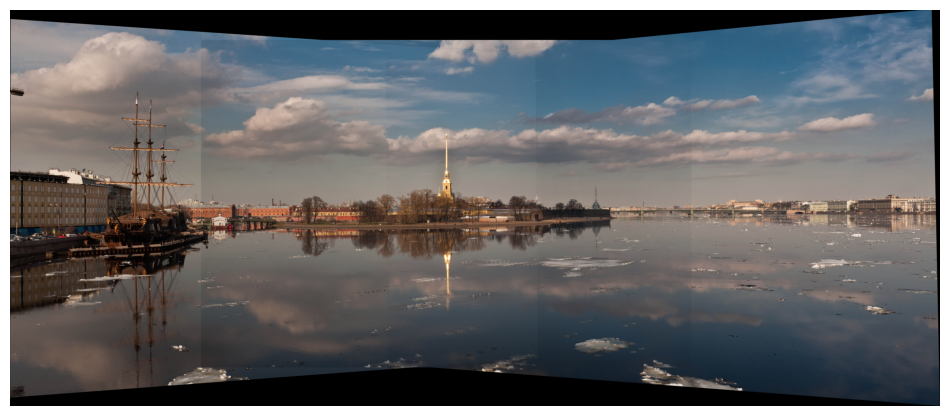

In [14]:
# CELDA E: paso 4 – prepara canvas y blend por promedio
# 4.1) calcula límites
h_c, w_c = central.shape[:2]
h_l, w_l = left.shape[:2]
h_r, w_r = right.shape[:2]

corn_c = np.float32([[0,0],[0,h_c],[w_c,h_c],[w_c,0]]).reshape(-1,1,2)
corn_l = np.float32([[0,0],[0,h_l],[w_l,h_l],[w_l,0]]).reshape(-1,1,2)
corn_r = np.float32([[0,0],[0,h_r],[w_r,h_r],[w_r,0]]).reshape(-1,1,2)

proj_l = cv.perspectiveTransform(corn_l, H_left)
proj_r = cv.perspectiveTransform(corn_r, H_right)

all_pts = np.vstack((corn_c, proj_l, proj_r))
x_min, y_min = np.int32(all_pts.min(axis=0).ravel() - 0.5)
x_max, y_max = np.int32(all_pts.max(axis=0).ravel() + 0.5)

offset   = [-x_min, -y_min]
canvas_w = x_max - x_min
canvas_h = y_max - y_min

# 4.2) traslación T
T = np.array([[1, 0, offset[0]],
              [0, 1, offset[1]],
              [0, 0,        1   ]], dtype=np.float32)

# 4.3) acumuladores
acc   = np.zeros((canvas_h, canvas_w, 3), dtype=np.float32)
count = np.zeros((canvas_h, canvas_w),      dtype=np.float32)

# 4.4) warpea y acumula
warp_and_accumulate(central, np.eye(3, dtype=np.float32),
                    T, (canvas_h, canvas_w), acc, count)
warp_and_accumulate(left, H_left, T, (canvas_h, canvas_w), acc, count)
warp_and_accumulate(right, H_right, T, (canvas_h, canvas_w), acc, count)

# 4.5) promedio
valid = count>0
result = np.zeros_like(acc, np.uint8)
result[valid] = (acc[valid] / count[valid,None]).astype(np.uint8)

# 4.6) muestra
plt.figure(figsize=(12,6))
plt.imshow(cv.cvtColor(result, cv.COLOR_BGR2RGB))
plt.axis('off')
